In [ ]:
!wget https://github.com/fregu856/deeplabv3/raw/master/pretrained_models/resnet/resnet18-5c106cde.pth

--2020-06-14 04:13:14--  https://github.com/fregu856/deeplabv3/raw/master/pretrained_models/resnet/resnet18-5c106cde.pth
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fregu856/deeplabv3/master/pretrained_models/resnet/resnet18-5c106cde.pth [following]
--2020-06-14 04:13:15--  https://raw.githubusercontent.com/fregu856/deeplabv3/master/pretrained_models/resnet/resnet18-5c106cde.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46827520 (45M) [application/octet-stream]
Saving to: ‘resnet18-5c106cde.pth’

resnet18-5c106cde.p 100%[===================>]  44.66M  63.2MB/s    in 0.7s    

2020-06-14 04:

# ASPP

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ASPP(nn.Module):
    def __init__(self, num_classes):
        super(ASPP, self).__init__()

        self.conv_1x1_1 = nn.Conv2d(512, 256, kernel_size=1)
        self.bn_conv_1x1_1 = nn.BatchNorm2d(256)

        self.conv_3x3_1 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=6, dilation=6)
        self.bn_conv_3x3_1 = nn.BatchNorm2d(256)

        self.conv_3x3_2 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=12, dilation=12)
        self.bn_conv_3x3_2 = nn.BatchNorm2d(256)

        self.conv_3x3_3 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=18, dilation=18)
        self.bn_conv_3x3_3 = nn.BatchNorm2d(256)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.conv_1x1_2 = nn.Conv2d(512, 256, kernel_size=1)
        self.bn_conv_1x1_2 = nn.BatchNorm2d(256)

        self.conv_1x1_3 = nn.Conv2d(1280, 256, kernel_size=1) # (1280 = 5*256)
        self.bn_conv_1x1_3 = nn.BatchNorm2d(256)

        self.conv_1x1_4 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, feature_map):
        # (feature_map has shape (batch_size, 512, h/16, w/16)) (assuming self.resnet is ResNet18_OS16 or ResNet34_OS16. If self.resnet instead is ResNet18_OS8 or ResNet34_OS8, it will be (batch_size, 512, h/8, w/8))

        feature_map_h = feature_map.size()[2] # (== h/16)
        feature_map_w = feature_map.size()[3] # (== w/16)

        out_1x1 = F.relu(self.bn_conv_1x1_1(self.conv_1x1_1(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_1 = F.relu(self.bn_conv_3x3_1(self.conv_3x3_1(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_2 = F.relu(self.bn_conv_3x3_2(self.conv_3x3_2(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_3 = F.relu(self.bn_conv_3x3_3(self.conv_3x3_3(feature_map))) # (shape: (batch_size, 256, h/16, w/16))

        out_img = self.avg_pool(feature_map) # (shape: (batch_size, 512, 1, 1))
        out_img = F.relu(self.bn_conv_1x1_2(self.conv_1x1_2(out_img))) # (shape: (batch_size, 256, 1, 1))
        out_img = F.upsample(out_img, size=(feature_map_h, feature_map_w), mode="bilinear") # (shape: (batch_size, 256, h/16, w/16))

        out = torch.cat([out_1x1, out_3x3_1, out_3x3_2, out_3x3_3, out_img], 1) # (shape: (batch_size, 1280, h/16, w/16))
        out = F.relu(self.bn_conv_1x1_3(self.conv_1x1_3(out))) # (shape: (batch_size, 256, h/16, w/16))
        out = self.conv_1x1_4(out) # (shape: (batch_size, num_classes, h/16, w/16))

        return out

class ASPP_Bottleneck(nn.Module):
    def __init__(self, num_classes):
        super(ASPP_Bottleneck, self).__init__()

        self.conv_1x1_1 = nn.Conv2d(4*512, 256, kernel_size=1)
        self.bn_conv_1x1_1 = nn.BatchNorm2d(256)

        self.conv_3x3_1 = nn.Conv2d(4*512, 256, kernel_size=3, stride=1, padding=6, dilation=6)
        self.bn_conv_3x3_1 = nn.BatchNorm2d(256)

        self.conv_3x3_2 = nn.Conv2d(4*512, 256, kernel_size=3, stride=1, padding=12, dilation=12)
        self.bn_conv_3x3_2 = nn.BatchNorm2d(256)

        self.conv_3x3_3 = nn.Conv2d(4*512, 256, kernel_size=3, stride=1, padding=18, dilation=18)
        self.bn_conv_3x3_3 = nn.BatchNorm2d(256)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.conv_1x1_2 = nn.Conv2d(4*512, 256, kernel_size=1)
        self.bn_conv_1x1_2 = nn.BatchNorm2d(256)

        self.conv_1x1_3 = nn.Conv2d(1280, 256, kernel_size=1) # (1280 = 5*256)
        self.bn_conv_1x1_3 = nn.BatchNorm2d(256)

        self.conv_1x1_4 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, feature_map):
        # (feature_map has shape (batch_size, 4*512, h/16, w/16))

        feature_map_h = feature_map.size()[2] # (== h/16)
        feature_map_w = feature_map.size()[3] # (== w/16)

        out_1x1 = F.relu(self.bn_conv_1x1_1(self.conv_1x1_1(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_1 = F.relu(self.bn_conv_3x3_1(self.conv_3x3_1(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_2 = F.relu(self.bn_conv_3x3_2(self.conv_3x3_2(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_3 = F.relu(self.bn_conv_3x3_3(self.conv_3x3_3(feature_map))) # (shape: (batch_size, 256, h/16, w/16))

        out_img = self.avg_pool(feature_map) # (shape: (batch_size, 512, 1, 1))
        out_img = F.relu(self.bn_conv_1x1_2(self.conv_1x1_2(out_img))) # (shape: (batch_size, 256, 1, 1))
        out_img = F.upsample(out_img, size=(feature_map_h, feature_map_w), mode="bilinear") # (shape: (batch_size, 256, h/16, w/16))

        out = torch.cat([out_1x1, out_3x3_1, out_3x3_2, out_3x3_3, out_img], 1) # (shape: (batch_size, 1280, h/16, w/16))
        out = F.relu(self.bn_conv_1x1_3(self.conv_1x1_3(out))) # (shape: (batch_size, 256, h/16, w/16))
        out = self.conv_1x1_4(out) # (shape: (batch_size, num_classes, h/16, w/16))

        return out

# RESNET

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

def make_layer(block, in_channels, channels, num_blocks, stride=1, dilation=1):
    strides = [stride] + [1]*(num_blocks - 1) # (stride == 2, num_blocks == 4 --> strides == [2, 1, 1, 1])

    blocks = []
    for stride in strides:
        blocks.append(block(in_channels=in_channels, channels=channels, stride=stride, dilation=dilation))
        in_channels = block.expansion*channels

    layer = nn.Sequential(*blocks) # (*blocks: call with unpacked list entires as arguments)

    return layer

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, channels, stride=1, dilation=1):
        super(BasicBlock, self).__init__()

        out_channels = self.expansion*channels

        self.conv1 = nn.Conv2d(in_channels, channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)

        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=dilation, dilation=dilation, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

        if (stride != 1) or (in_channels != out_channels):
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
            bn = nn.BatchNorm2d(out_channels)
            self.downsample = nn.Sequential(conv, bn)
        else:
            self.downsample = nn.Sequential()

    def forward(self, x):
        # (x has shape: (batch_size, in_channels, h, w))

        out = F.relu(self.bn1(self.conv1(x))) # (shape: (batch_size, channels, h, w) if stride == 1, (batch_size, channels, h/2, w/2) if stride == 2)
        out = self.bn2(self.conv2(out)) # (shape: (batch_size, channels, h, w) if stride == 1, (batch_size, channels, h/2, w/2) if stride == 2)

        out = out + self.downsample(x) # (shape: (batch_size, channels, h, w) if stride == 1, (batch_size, channels, h/2, w/2) if stride == 2)

        out = F.relu(out) # (shape: (batch_size, channels, h, w) if stride == 1, (batch_size, channels, h/2, w/2) if stride == 2)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, channels, stride=1, dilation=1):
        super(Bottleneck, self).__init__()

        out_channels = self.expansion*channels

        self.conv1 = nn.Conv2d(in_channels, channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)

        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

        self.conv3 = nn.Conv2d(channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        if (stride != 1) or (in_channels != out_channels):
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
            bn = nn.BatchNorm2d(out_channels)
            self.downsample = nn.Sequential(conv, bn)
        else:
            self.downsample = nn.Sequential()

    def forward(self, x):
        # (x has shape: (batch_size, in_channels, h, w))

        out = F.relu(self.bn1(self.conv1(x))) # (shape: (batch_size, channels, h, w))
        out = F.relu(self.bn2(self.conv2(out))) # (shape: (batch_size, channels, h, w) if stride == 1, (batch_size, channels, h/2, w/2) if stride == 2)
        out = self.bn3(self.conv3(out)) # (shape: (batch_size, out_channels, h, w) if stride == 1, (batch_size, out_channels, h/2, w/2) if stride == 2)

        out = out + self.downsample(x) # (shape: (batch_size, out_channels, h, w) if stride == 1, (batch_size, out_channels, h/2, w/2) if stride == 2)

        out = F.relu(out) # (shape: (batch_size, out_channels, h, w) if stride == 1, (batch_size, out_channels, h/2, w/2) if stride == 2)

        return out

class ResNet_Bottleneck_OS16(nn.Module):
    def __init__(self, num_layers):
        super(ResNet_Bottleneck_OS16, self).__init__()

        if num_layers == 50:
            resnet = models.resnet50()
            # load pretrained model:
            resnet.load_state_dict(torch.load("/root/deeplabv3/pretrained_models/resnet/resnet50-19c8e357.pth"))
            # remove fully connected layer, avg pool and layer5:
            self.resnet = nn.Sequential(*list(resnet.children())[:-3])

            print ("pretrained resnet, 50")
        elif num_layers == 101:
            resnet = models.resnet101()
            # load pretrained model:
            resnet.load_state_dict(torch.load("/root/deeplabv3/pretrained_models/resnet/resnet101-5d3b4d8f.pth"))
            # remove fully connected layer, avg pool and layer5:
            self.resnet = nn.Sequential(*list(resnet.children())[:-3])

            print ("pretrained resnet, 101")
        elif num_layers == 152:
            resnet = models.resnet152()
            # load pretrained model:
            resnet.load_state_dict(torch.load("/root/deeplabv3/pretrained_models/resnet/resnet152-b121ed2d.pth"))
            # remove fully connected layer, avg pool and layer5:
            self.resnet = nn.Sequential(*list(resnet.children())[:-3])

            print ("pretrained resnet, 152")
        else:
            raise Exception("num_layers must be in {50, 101, 152}!")

        self.layer5 = make_layer(Bottleneck, in_channels=4*256, channels=512, num_blocks=3, stride=1, dilation=2)

    def forward(self, x):
        # (x has shape (batch_size, 3, h, w))

        # pass x through (parts of) the pretrained ResNet:
        c4 = self.resnet(x) # (shape: (batch_size, 4*256, h/16, w/16)) (it's called c4 since 16 == 2^4)

        output = self.layer5(c4) # (shape: (batch_size, 4*512, h/16, w/16))

        return output

class ResNet_BasicBlock_OS16(nn.Module):
    def __init__(self, num_layers):
        super(ResNet_BasicBlock_OS16, self).__init__()

        if num_layers == 18:
            resnet = models.resnet18()
            # load pretrained model:
            resnet.load_state_dict(torch.load("/root/deeplabv3/pretrained_models/resnet/resnet18-5c106cde.pth"))
            # remove fully connected layer, avg pool and layer5:
            self.resnet = nn.Sequential(*list(resnet.children())[:-3])

            num_blocks = 2
            print ("pretrained resnet, 18")
        elif num_layers == 34:
            resnet = models.resnet34()
            # load pretrained model:
            resnet.load_state_dict(torch.load("/root/deeplabv3/pretrained_models/resnet/resnet34-333f7ec4.pth"))
            # remove fully connected layer, avg pool and layer5:
            self.resnet = nn.Sequential(*list(resnet.children())[:-3])

            num_blocks = 3
            print ("pretrained resnet, 34")
        else:
            raise Exception("num_layers must be in {18, 34}!")

        self.layer5 = make_layer(BasicBlock, in_channels=256, channels=512, num_blocks=num_blocks, stride=1, dilation=2)

    def forward(self, x):
        # (x has shape (batch_size, 3, h, w))

        # pass x through (parts of) the pretrained ResNet:
        c4 = self.resnet(x) # (shape: (batch_size, 256, h/16, w/16)) (it's called c4 since 16 == 2^4)

        output = self.layer5(c4) # (shape: (batch_size, 512, h/16, w/16))

        return output

class ResNet_BasicBlock_OS8(nn.Module):
    def __init__(self, num_layers):
        super(ResNet_BasicBlock_OS8, self).__init__()

        if num_layers == 18:
            resnet = models.resnet18()
            # load pretrained model:
            resnet.load_state_dict(torch.load("resnet18-5c106cde.pth"))
            # remove fully connected layer, avg pool, layer4 and layer5:
            self.resnet = nn.Sequential(*list(resnet.children())[:-4])

            num_blocks_layer_4 = 2
            num_blocks_layer_5 = 2
            print ("pretrained resnet, 18")
        elif num_layers == 34:
            resnet = models.resnet34()
            # load pretrained model:
            resnet.load_state_dict(torch.load("/root/deeplabv3/pretrained_models/resnet/resnet34-333f7ec4.pth"))
            # remove fully connected layer, avg pool, layer4 and layer5:
            self.resnet = nn.Sequential(*list(resnet.children())[:-4])

            num_blocks_layer_4 = 6
            num_blocks_layer_5 = 3
            print ("pretrained resnet, 34")
        else:
            raise Exception("num_layers must be in {18, 34}!")

        self.layer4 = make_layer(BasicBlock, in_channels=128, channels=256, num_blocks=num_blocks_layer_4, stride=1, dilation=2)

        self.layer5 = make_layer(BasicBlock, in_channels=256, channels=512, num_blocks=num_blocks_layer_5, stride=1, dilation=4)

    def forward(self, x):
        # (x has shape (batch_size, 3, h, w))

        # pass x through (parts of) the pretrained ResNet:
        c3 = self.resnet(x) # (shape: (batch_size, 128, h/8, w/8)) (it's called c3 since 8 == 2^3)

        output = self.layer4(c3) # (shape: (batch_size, 256, h/8, w/8))
        output = self.layer5(output) # (shape: (batch_size, 512, h/8, w/8))

        return output

def ResNet18_OS16():
    return ResNet_BasicBlock_OS16(num_layers=18)

def ResNet34_OS16():
    return ResNet_BasicBlock_OS16(num_layers=34)

def ResNet50_OS16():
    return ResNet_Bottleneck_OS16(num_layers=50)

def ResNet101_OS16():
    return ResNet_Bottleneck_OS16(num_layers=101)

def ResNet152_OS16():
    return ResNet_Bottleneck_OS16(num_layers=152)

def ResNet18_OS8():
    return ResNet_BasicBlock_OS8(num_layers=18)

def ResNet34_OS8():
    return ResNet_BasicBlock_OS8(num_layers=34)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os

class DeepLabV3(nn.Module):
    def __init__(self, model_id):
        super(DeepLabV3, self).__init__()

        self.num_classes = 6

        self.model_id = model_id

        self.resnet = ResNet18_OS8() # NOTE! specify the type of ResNet here
        self.aspp = ASPP(num_classes=self.num_classes) # NOTE! if you use ResNet50-152, set self.aspp = ASPP_Bottleneck(num_classes=self.num_classes) instead

    def forward(self, x):
        # (x has shape (batch_size, 3, h, w))

        h = x.size()[2]
        w = x.size()[3]

        feature_map = self.resnet(x) # (shape: (batch_size, 512, h/16, w/16)) (assuming self.resnet is ResNet18_OS16 or ResNet34_OS16. If self.resnet is ResNet18_OS8 or ResNet34_OS8, it will be (batch_size, 512, h/8, w/8). If self.resnet is ResNet50-152, it will be (batch_size, 4*512, h/16, w/16))

        output = self.aspp(feature_map) # (shape: (batch_size, num_classes, h/16, w/16))

        output = F.upsample(output, size=(h, w), mode="bilinear") # (shape: (batch_size, num_classes, h, w))

        return output

In [ ]:
import torch
import torch.nn as nn

import numpy as np

def add_weight_decay(net, l2_value, skip_list=()):
    # https://raberrytv.wordpress.com/2017/10/29/pytorch-weight-decay-made-easy/

    decay, no_decay = [], []
    for name, param in net.named_parameters():
        if not param.requires_grad:
            continue # frozen weights
        if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list:
            no_decay.append(param)
        else:
            decay.append(param)

    return [{'params': no_decay, 'weight_decay': 0.0}, {'params': decay, 'weight_decay': l2_value}]

# function for colorizing a label image:
def label_img_to_color(img):
    label_to_color = {
        0: [0, 0, 0],
        1: [244, 35,232],
        2: [ 70, 70, 70],
        3: [102,102,156],
        4: [190,153,153],
        5: [153,153,153]
    }

    img_height, img_width = img.shape

    img_color = np.zeros((img_height, img_width, 3))
    for row in range(img_height):
        for col in range(img_width):
            label = img[row, col]

            img_color[row, col] = np.array(label_to_color[label])

    return img_color

In [ ]:
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pickle
# import matplotlib
# matplotlib.use("Agg")
import matplotlib.pyplot as plt
import cv2

## Prepare data

In [ ]:
!gdown https://drive.google.com/uc?id=19WjVFsLOgELWn3VYrwCd8KIMm3go57IB

Downloading...
From: https://drive.google.com/uc?id=19WjVFsLOgELWn3VYrwCd8KIMm3go57IB
To: /content/segmentation_dataset_new.zip
182MB [00:00, 238MB/s]


In [ ]:
!unzip segmentation_dataset_new.zip

In [ ]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.torch import ToTensor
warnings.filterwarnings("ignore")
%matplotlib inline

## Computed Class Weights for Cross Entropy

In [ ]:
weights = [1.6253095541599483, 27.374704875461912, 43.44600342709819, 42.82736864275733, 40.52256280615426, 6.7084107992796485]
class_weights = torch.FloatTensor(weights).cuda()

In [ ]:
training_set = []
validation_set = []

with open("segmentation_dataset/train.txt") as f:
  contents = f.readlines()

for content in contents:
  training_set.append(content.replace("\n", ''))

with open("segmentation_dataset/valid.txt") as f:
  contents = f.readlines()

for content in contents:
  validation_set.append(content.replace("\n", ''))

In [ ]:
import albumentations as albu

def get_transforms(phase, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(p=0.4),
                ShiftScaleRotate(
                    shift_limit=0,  # no resizing
                    scale_limit=0.1,
                    rotate_limit=10, # rotate
                    p=0.2,
                    border_mode=cv2.BORDER_CONSTANT
                ),
                # # albu.RandomRotate90(),
                # albu.Cutout(),
                albu.RandomBrightnessContrast(
                    brightness_limit=0.2, contrast_limit=0.2, p=0.2
                )
                # # albu.GridDistortion(p=0.3),
                # albu.HueSaturationValue(p=0.2),
                # albu.RandomContrast(p=0.2),
                # albu.MedianBlur(p=0.2)
            ]
        )
    # list_transforms.extend(
    #     [
    #         Resize(640, 960, interpolation=cv2.INTER_NEAREST)
    #         # Normalize(mean=mean, std=std, p=1),
    #         # ToTensor(),
    #     ]
    # )

    list_trfms = Compose(list_transforms)
    return list_trfms

In [ ]:
def generate_mask(mask):
  mask_palette = [1, 2, 3, 4, 5, 7]

  palette_dict = {
      1: 1,
      2: 2,
      3: 3,
      4: 4,
      5: 5 ,
      7: 0
  }

  new_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float32)

  for palette in mask_palette:
    new_mask[mask == palette] = palette_dict[palette]
  return new_mask


In [ ]:
from PIL import Image
import torchvision

image_prefix = "/content/segmentation_dataset/new_img/"
color_mask_prefix = "/content/segmentation_dataset/new_color_mask/"
binary_mask_prefix = "/content/segmentation_dataset/mask/"


class DPWHDataset(Dataset):
  def __init__(self, mean=None, std=None, phase=None, dataset=None):
    self.data = dataset
    self.mean = mean
    self.std = std
    self.phase = phase
    self.transforms = get_transforms(phase, mean, std)
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image_name = self.data[idx]

    image_path = image_prefix + image_name + ".jpg"
    mask_path = binary_mask_prefix + image_name + "_mask.png"
    # print(mask_path)

    mask = cv2.imread(mask_path, 0)

    image = np.array(Image.open(image_path))
    # mask = np.array(Image.open(mask_path))
    mask = np.array(torchvision.transforms.ToPILImage()(mask))
    # image = cv2.imread(image_path)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    augmented = self.transforms(image=image, mask=mask)
    image = augmented['image']
    mask = augmented['mask']

    # mask = np.array(mask)

    mask = generate_mask(mask)

    image = torchvision.transforms.ToTensor()(image)
    image = torchvision.transforms.Normalize(mean=self.mean, std=self.std)(image)
    mask = torchvision.transforms.ToTensor()(mask).permute(1, 2, 0)
    return image, mask

In [ ]:
train_dataset = DPWHDataset(
    mean = (0.485, 0.456, 0.406),
    std = (0.229, 0.224, 0.225),
    phase = 'train',
    dataset = training_set
)

val_dataset = DPWHDataset(
    mean = (0.485, 0.456, 0.406),
    std = (0.229, 0.224, 0.225),
    phase = 'val',
    dataset = validation_set
)

In [ ]:
fake_loader = DataLoader(train_dataset, batch_size=2,
                          pin_memory=True, shuffle=True)
batch = next(iter(fake_loader)) # get a batch from the dataloader
images, masks = batch

In [ ]:
images.shape

torch.Size([2, 3, 600, 900])

In [ ]:
masks.squeeze().shape

torch.Size([2, 600, 900])

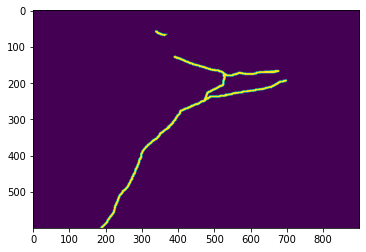

In [ ]:
plt.imshow(masks[0].squeeze())

### Our U-Net

In [ ]:
from collections import defaultdict
import torch.nn.functional as F
import torch.nn as nn

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def dice_loss_gen(inp, targ):
    inp = inp.contiguous().permute(0, 2, 3, 1)
    targ = targ.contiguous().permute(0, 2, 3, 1)

    w = torch.zeros((targ.shape[-1],))
    w = 1. / (torch.sum(targ, (0, 1, 2))**2 + 1e-9)

    numerator = targ * inp
    numerator = w * torch.sum(numerator, (0, 1, 2))
    numerator = torch.sum(numerator)

    denominator = targ + inp
    denominator = w * torch.sum(denominator, (0, 1, 2))
    denominator = torch.sum(denominator)

    dice = 2. * (numerator + 1e-9) / (denominator + 1e-9)

    return 1. - dice

def calc_loss(pred, target, metrics, bce_weight=0.5):
    # print(f"Shape of pred {pred.shape} and Shape of Target: {target.shape}")
    bce = F.cross_entropy(pred, target)
    # 4, 600, 900, 1
    # pred = F.sigmoid(pred)
    pred = F.softmax(pred)
    # pred = pred.permute(0, 2, 3, 1)
    # pred = pred.data.cpu().numpy()
    # pred = np.argmax(pred, axis=-1)
    # pred = torch.from_numpy(pred).to(device)
    # # pred = pred.to(device)
    # target = torch.unsqueeze(target, 1)
    # pred = torch.unsqueeze(pred, 1)
    # print(pred.shape, target.shape)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]

def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou

import torch
import torch.nn as nn
from torchvision import models

def match_shapes(x, y):
    if x.shape[-2:] != y.shape[-2:]:
        x = F.interpolate(x, y.shape[-2:], mode='nearest')

    return x

def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
      nn.ReLU(inplace=True)
  )

class ResNetUNet(nn.Module):
  def __init__(self, n_class=1):
    super().__init__()

    self.base_model = models.resnet18(pretrained=True)
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = match_shapes(x, layer3)
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = match_shapes(x, layer2)
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = match_shapes(x, layer1)
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

In [ ]:
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, 
                          pin_memory=True, num_workers=4, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=4, 
                          pin_memory=True, num_workers=4, shuffle=True),
}

bces = {'train': [],'val': []}
losses = {'train': [],'val': []}
dices = {'train': [],'val': []}
ious = {'train': [],'val': []}

def train_model(model, optimizer, scheduler, num_epochs=25):
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 1e10

  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)

      since = time.time()

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          if phase == 'train':
              scheduler.step()
              for param_group in optimizer.param_groups:
                  print("LR", param_group['lr'])

              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          metrics = defaultdict(float)
          epoch_samples = 0

          # MASK TARGET: torch.Size([4, 1, 600, 900, 3])
          # OUTPUT: torch.Size([4, 5, 600, 900]
          # (torch.Size([4, 1, 320, 480, 6])) must be the same as input size (torch.Size([4, 6, 320, 480]))
          for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.type(torch.LongTensor)
              labels = labels.squeeze()
              labels = labels.to(device)
            
              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  loss = calc_loss(outputs, labels, metrics)

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()
                      # scheduler.step()

              # statistics
              epoch_samples += inputs.size(0)

          print_metrics(metrics, epoch_samples, phase)
          epoch_loss = metrics['loss'] / epoch_samples
          bces[phase].append(metrics['bce'] / epoch_samples)
          dices[phase].append(1 - (metrics['dice'] / epoch_samples))
          losses[phase].append(metrics['loss'] / epoch_samples)

          # deep copy the model
          if phase == 'val' and epoch_loss < best_loss:
              print("saving best model")
              best_loss = epoch_loss
              best_model_wts = copy.deepcopy(model.state_dict())

      time_elapsed = time.time() - since
      print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

  print('Best val loss: {:4f}'.format(best_loss))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, metrics

In [ ]:
def plot(scores, name):
    plt.figure(figsize=(6,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    # plt.show()

cuda:0
###########################
######## NEW EPOCH ########
###########################
epoch: 1/50
------------------------
Epoch 0: Train Loss: 1.3630694150924683 Val Loss: 1.7762161493301392
###########################
######## NEW EPOCH ########
###########################
epoch: 2/50
------------------------
Epoch 1: Train Loss: 1.2452603578567505 Val Loss: 1.199666142463684
###########################
######## NEW EPOCH ########
###########################
epoch: 3/50
------------------------
Epoch 2: Train Loss: 1.1815741062164307 Val Loss: 1.1974109411239624
###########################
######## NEW EPOCH ########
###########################
epoch: 4/50
------------------------
Epoch 3: Train Loss: 1.1866888999938965 Val Loss: 1.1538050174713135
###########################
######## NEW EPOCH ########
###########################
epoch: 5/50
------------------------
Epoch 4: Train Loss: 1.09292471408844 Val Loss: 1.0459587574005127
###########################
######## NEW EPOCH

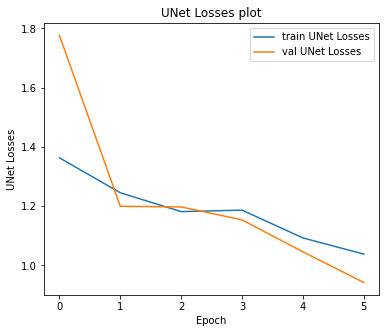

###########################
######## NEW EPOCH ########
###########################
epoch: 7/50
------------------------
Epoch 6: Train Loss: 0.9876297116279602 Val Loss: 0.9806356430053711
###########################
######## NEW EPOCH ########
###########################
epoch: 8/50
------------------------
Epoch 7: Train Loss: 0.9635652899742126 Val Loss: 0.8609982132911682
###########################
######## NEW EPOCH ########
###########################
epoch: 9/50
------------------------
Epoch 8: Train Loss: 0.9303358793258667 Val Loss: 0.8619438409805298
###########################
######## NEW EPOCH ########
###########################
epoch: 10/50
------------------------
Epoch 9: Train Loss: 0.913780689239502 Val Loss: 0.8473948240280151
###########################
######## NEW EPOCH ########
###########################
epoch: 11/50
------------------------
Epoch 10: Train Loss: 0.9149349927902222 Val Loss: 0.906755805015564


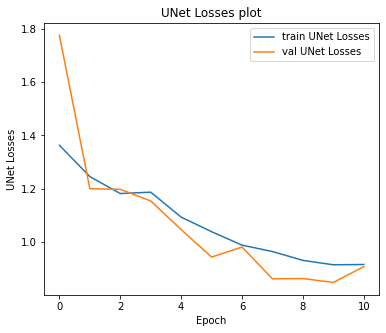

###########################
######## NEW EPOCH ########
###########################
epoch: 12/50
------------------------
Epoch 11: Train Loss: 0.9413243532180786 Val Loss: 0.9550305604934692
###########################
######## NEW EPOCH ########
###########################
epoch: 13/50
------------------------
Epoch 12: Train Loss: 0.8879119753837585 Val Loss: 0.8696519136428833
###########################
######## NEW EPOCH ########
###########################
epoch: 14/50
------------------------
Epoch 13: Train Loss: 0.8494600057601929 Val Loss: 0.9587239027023315
###########################
######## NEW EPOCH ########
###########################
epoch: 15/50
------------------------
Epoch 14: Train Loss: 0.8515332937240601 Val Loss: 0.8329309821128845
###########################
######## NEW EPOCH ########
###########################
epoch: 16/50
------------------------
Epoch 15: Train Loss: 0.8536190986633301 Val Loss: 0.932034432888031


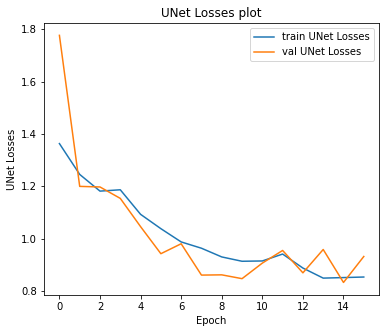

###########################
######## NEW EPOCH ########
###########################
epoch: 17/50
------------------------
Epoch 16: Train Loss: 0.8839171528816223 Val Loss: 0.803039014339447
###########################
######## NEW EPOCH ########
###########################
epoch: 18/50
------------------------
Epoch 17: Train Loss: 0.7914581894874573 Val Loss: 1.0421011447906494
###########################
######## NEW EPOCH ########
###########################
epoch: 19/50
------------------------
Epoch 18: Train Loss: 0.8247599601745605 Val Loss: 0.8392276167869568
###########################
######## NEW EPOCH ########
###########################
epoch: 20/50
------------------------
Epoch 19: Train Loss: 0.7642260193824768 Val Loss: 0.709710419178009
###########################
######## NEW EPOCH ########
###########################
epoch: 21/50
------------------------
Epoch 20: Train Loss: 0.7068734169006348 Val Loss: 0.9153543710708618


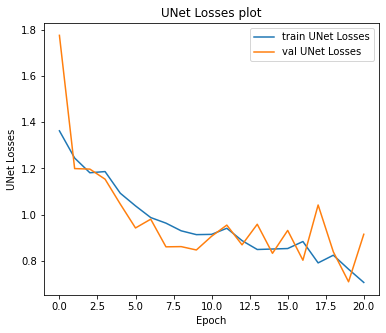

###########################
######## NEW EPOCH ########
###########################
epoch: 22/50
------------------------
Epoch 21: Train Loss: 0.6954502463340759 Val Loss: 1.0506155490875244
###########################
######## NEW EPOCH ########
###########################
epoch: 23/50
------------------------
Epoch 22: Train Loss: 0.727604866027832 Val Loss: 1.36221444606781
###########################
######## NEW EPOCH ########
###########################
epoch: 24/50
------------------------
Epoch 23: Train Loss: 0.6875596046447754 Val Loss: 0.7771790623664856
###########################
######## NEW EPOCH ########
###########################
epoch: 25/50
------------------------
Epoch 24: Train Loss: 0.7930751442909241 Val Loss: 0.8876820206642151
###########################
######## NEW EPOCH ########
###########################
epoch: 26/50
------------------------
Epoch 25: Train Loss: 0.7242916822433472 Val Loss: 0.8278509974479675


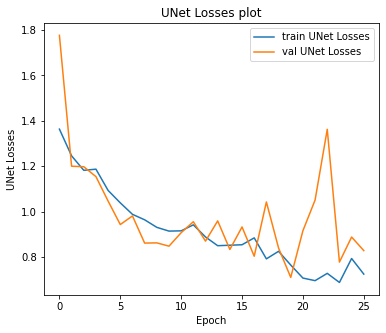

###########################
######## NEW EPOCH ########
###########################
epoch: 27/50
------------------------
Epoch 26: Train Loss: 0.6638265252113342 Val Loss: 0.6681187748908997
###########################
######## NEW EPOCH ########
###########################
epoch: 28/50
------------------------
Epoch 27: Train Loss: 0.6331449151039124 Val Loss: 0.9145694971084595
###########################
######## NEW EPOCH ########
###########################
epoch: 29/50
------------------------
Epoch 28: Train Loss: 0.580201268196106 Val Loss: 0.734176754951477
###########################
######## NEW EPOCH ########
###########################
epoch: 30/50
------------------------
Epoch 29: Train Loss: 0.6076753735542297 Val Loss: 0.6402236223220825
###########################
######## NEW EPOCH ########
###########################
epoch: 31/50
------------------------
Epoch 30: Train Loss: 0.5920179486274719 Val Loss: 0.930759072303772


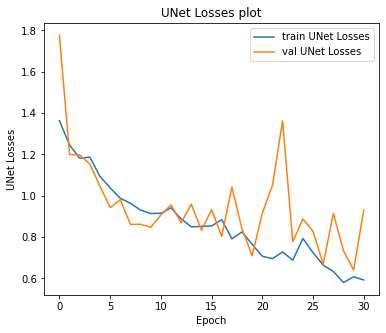

###########################
######## NEW EPOCH ########
###########################
epoch: 32/50
------------------------
Epoch 31: Train Loss: 0.6077142953872681 Val Loss: 0.632964551448822
###########################
######## NEW EPOCH ########
###########################
epoch: 33/50
------------------------
Epoch 32: Train Loss: 0.5572341680526733 Val Loss: 0.6400952339172363
###########################
######## NEW EPOCH ########
###########################
epoch: 34/50
------------------------
Epoch 33: Train Loss: 0.5046390891075134 Val Loss: 0.629741370677948
###########################
######## NEW EPOCH ########
###########################
epoch: 35/50
------------------------
Epoch 34: Train Loss: 0.4936424493789673 Val Loss: 0.6792003512382507
###########################
######## NEW EPOCH ########
###########################
epoch: 36/50
------------------------
Epoch 35: Train Loss: 0.4954674243927002 Val Loss: 0.6718211770057678


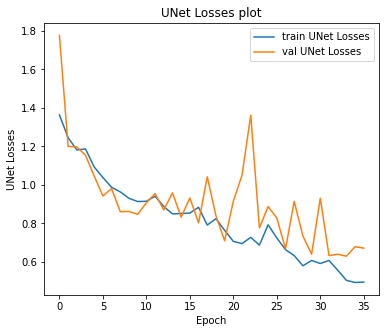

###########################
######## NEW EPOCH ########
###########################
epoch: 37/50
------------------------
Epoch 36: Train Loss: 0.8512518405914307 Val Loss: 0.9320451021194458
###########################
######## NEW EPOCH ########
###########################
epoch: 38/50
------------------------
Epoch 37: Train Loss: 0.7152025103569031 Val Loss: 0.6962803602218628
###########################
######## NEW EPOCH ########
###########################
epoch: 39/50
------------------------
Epoch 38: Train Loss: 0.6544046401977539 Val Loss: 0.7607938647270203
###########################
######## NEW EPOCH ########
###########################
epoch: 40/50
------------------------
Epoch 39: Train Loss: 0.5686230063438416 Val Loss: 0.6447882056236267
###########################
######## NEW EPOCH ########
###########################
epoch: 41/50
------------------------
Epoch 40: Train Loss: 0.5408106446266174 Val Loss: 0.6526218056678772


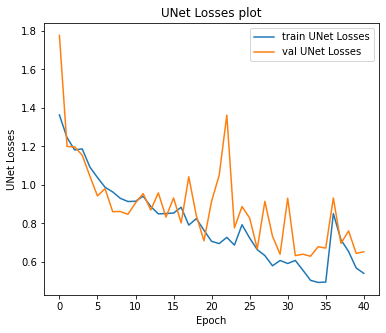

###########################
######## NEW EPOCH ########
###########################
epoch: 42/50
------------------------
Epoch 41: Train Loss: 0.5039775371551514 Val Loss: 0.6862570643424988
###########################
######## NEW EPOCH ########
###########################
epoch: 43/50
------------------------
Epoch 42: Train Loss: 0.42161473631858826 Val Loss: 0.6710556745529175
###########################
######## NEW EPOCH ########
###########################
epoch: 44/50
------------------------
Epoch 43: Train Loss: 0.43034884333610535 Val Loss: 0.6194008588790894
###########################
######## NEW EPOCH ########
###########################
epoch: 45/50
------------------------
Epoch 44: Train Loss: 0.4728730320930481 Val Loss: 0.6403388977050781
###########################
######## NEW EPOCH ########
###########################
epoch: 46/50
------------------------
Epoch 45: Train Loss: 0.4875844419002533 Val Loss: 0.7117868065834045


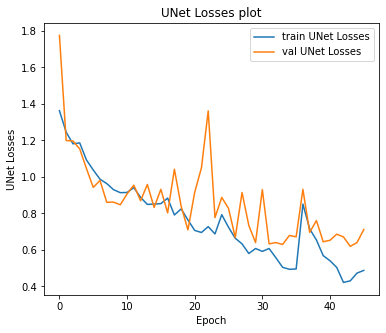

###########################
######## NEW EPOCH ########
###########################
epoch: 47/50
------------------------
Epoch 46: Train Loss: 0.44445574283599854 Val Loss: 0.599077582359314
###########################
######## NEW EPOCH ########
###########################
epoch: 48/50
------------------------
Epoch 47: Train Loss: 0.4003405272960663 Val Loss: 0.6015628576278687
###########################
######## NEW EPOCH ########
###########################
epoch: 49/50
------------------------
Epoch 48: Train Loss: 0.39958247542381287 Val Loss: 0.7222062349319458
###########################
######## NEW EPOCH ########
###########################
epoch: 50/50
------------------------
Epoch 49: Train Loss: 0.41769707202911377 Val Loss: 0.8214706182479858


In [ ]:
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, 
                          pin_memory=True, num_workers=4, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=4, 
                          pin_memory=True, num_workers=4, shuffle=True),
}

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

network = ResNetUNet(n_class=6).to(device)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
# model, loss_train, loss_val = model_train(model, optimizer_ft, exp_lr_scheduler, num_epochs=15)

epoch_losses_train = []
epoch_losses_val = []
learning_rate = 0.0005
# params = add_weight_decay(network, l2_value=0.0001)
# optimizer = torch.optim.Adam(params, lr=learning_rate)
params = add_weight_decay(network, l2_value=0.0001)
optimizer = torch.optim.AdamW(params, lr=learning_rate)
num_epochs = 50
# scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=3, verbose=True)
# loss_fn = nn.CrossEntropyLoss(weight=class_weights)
for epoch in range(num_epochs):
    print ("###########################")
    print ("######## NEW EPOCH ########")
    print ("###########################")
    print ("epoch: %d/%d" % (epoch+1, num_epochs))

    ############################################################################
    # train:
    ############################################################################
    network.train() # (set in training mode, this affects BatchNorm and dropout)
    batch_losses = []
    for step, (inputs, labels) in enumerate(dataloaders['train']):
        #current_time = time.time()

        # imgs = Variable(imgs).cuda() # (shape: (batch_size, 3, img_h, img_w))
        # label_imgs = Variable(label_imgs.type(torch.LongTensor)).cuda() # (shape: (batch_size, img_h, img_w))
        inputs = inputs.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.squeeze()
        labels = labels.to(device)

        outputs = network(inputs) # (shape: (batch_size, num_classes, img_h, img_w))
        # print(outputs.shape, labels.shape)
        # compute the loss:
        # outputs = F.softmax(outputs)
        loss = loss_fn(outputs, labels)
        loss_value = loss.data.cpu().numpy()
        batch_losses.append(loss_value)

        # optimization step:
        optimizer.zero_grad() # (reset gradients)
        loss.backward() # (compute gradients)
        optimizer.step() # (perform optimization step)

        #print (time.time() - current_time)

    epoch_loss_train = np.mean(batch_losses)
    epoch_losses_train.append(epoch_loss_train)

    ############################################################################
    # val:
    ############################################################################
    network.eval() # (set in evaluation mode, this affects BatchNorm and dropout)
    batch_losses = []
    for step, (inputs, labels) in enumerate(dataloaders['val']):
        with torch.no_grad(): # (corresponds to setting volatile=True in all variables, this is done during inference to reduce memory consumption)
          # imgs = Variable(imgs).cuda() # (shape: (batch_size, 3, img_h, img_w))
          # label_imgs = Variable(label_imgs.type(torch.LongTensor)).cuda() # (shape: (batch_size, img_h, img_w))

          # outputs = network(imgs) # (shape: (batch_size, num_classes, img_h, img_w))
          inputs = inputs.to(device)
          labels = labels.type(torch.LongTensor)
          labels = labels.squeeze()
          labels = labels.to(device)
          outputs = network(inputs)
          # outputs = F.softmax(outputs)
          
          # print(outputs.shape, labels.shape)

          # compute the loss:
          loss = loss_fn(outputs, labels)
          # scheduler.step(loss)
          loss_value = loss.data.cpu().numpy()
          batch_losses.append(loss_value)
    epoch_loss_val = np.mean(batch_losses)
    epoch_losses_val.append(epoch_loss_val)

    print("------------------------")
    print(f"Epoch {epoch}: Train Loss: {epoch_loss_train} Val Loss: {epoch_loss_val}")

    if epoch % 5 == 0 and epoch > 0:
      new_scores = {
          'train': epoch_losses_train,
          'val': epoch_losses_val
      }

      plot(new_scores, "UNet Losses")
      checkpoint_path = "unet_model_states.pth".format(str(epoch))
      path_full = "unet_model_states_full.pth".format(str(epoch))
      torch.save(network, path_full)
      torch.save({
          'network_states': network.state_dict(),
          'optimizer': optimizer,
          'loss': loss
          }, checkpoint_path)

In [ ]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = ResNetUNet(n_class=6).to(device)

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)
model, loss_train, loss_val = model_train(model, optimizer_ft, exp_lr_scheduler, num_epochs=15)

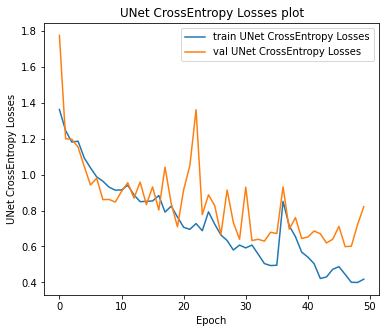

In [ ]:
def plot(scores, name):
    plt.figure(figsize=(6,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

new_scores = {
    'train': epoch_losses_train,
    'val': epoch_losses_val
}

plot(new_scores, "UNet CrossEntropy Losses")

In [ ]:
model = torch.load("unet_model_states_full.pth")

## Testing

In [ ]:
fake_loader = DataLoader(val_dataset, batch_size=2,
                          pin_memory=True, shuffle=True)
batch = next(iter(fake_loader)) # get a batch from the dataloader
images, masks = batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


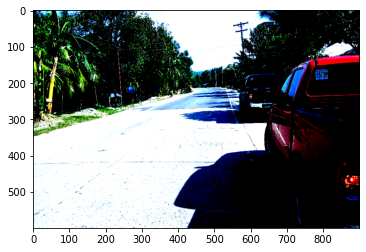

In [ ]:
plt.imshow(images[0].permute(1, 2, 0))

In [ ]:
masks.squeeze().shape

torch.Size([2, 600, 900])

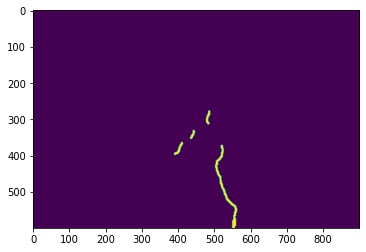

In [ ]:
plt.imshow(masks[0].squeeze())

In [ ]:
with torch.no_grad():
  model.eval()
  # preds = torch.sigmoid(model.to(device)(images.to(device)))
  # preds = preds.detach().cpu().numpy()[:, 0, :, :] # (batch_size, 1, size, size) -> (batch_size, size, size)
  pred = model(images.to(device))
  print(pred.shape)
  # The loss functions include the sigmoid function.
  pred = F.softmax(pred)
  pred = pred.permute(0, 2, 3, 1)
  pred = pred.data.cpu().numpy()
  print(pred.shape)
  # pred = np.argmax(pred, axis=-1)
  # sample_output = torch.argmax(model(images.to(device)), 1)
  # print(sample_output.shape)
  # sample_output = sample_output.detach().cpu().numpy()

torch.Size([2, 6, 600, 900])
(2, 600, 900, 6)


In [ ]:
new_pred = pred[0]
new_pred = np.argmax(new_pred, axis=-1)
new_pred.shape

(600, 900)

In [ ]:
new_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 5, 0],
       [0, 0, 0, ..., 5, 5, 0],
       ...,
       [0, 0, 0, ..., 5, 5, 5],
       [0, 0, 0, ..., 5, 5, 5],
       [0, 5, 5, ..., 5, 5, 5]])

In [ ]:
def label_img_to_color(img):
    label_to_color = {
        0: [0, 0, 0],
        1: [52, 64, 235],   # kinda red     allgigator
        2: [230, 103, 39],  # kinda blue    bowl
        3: [46, 222, 11],   # kinda green   delamination
        4: [19, 228, 232],  # kinda yellow  crack
        5: [183, 222, 11]   # kinda sky blye  scaling
      }

    img_height, img_width = img.shape

    img_color = np.zeros((img_height, img_width, 3))
    for row in range(img_height):
        for col in range(img_width):
            label = img[row, col]

            img_color[row, col] = np.array(label_to_color[label])

    return img_color

In [ ]:
new_pred = label_img_to_color(new_pred)
new_pred.shape
# from google.colab.patches import cv2_imshow
# cv2_imshow(new_pred)
# cv2.imwrite("new.png", new_pred)

(600, 900, 3)

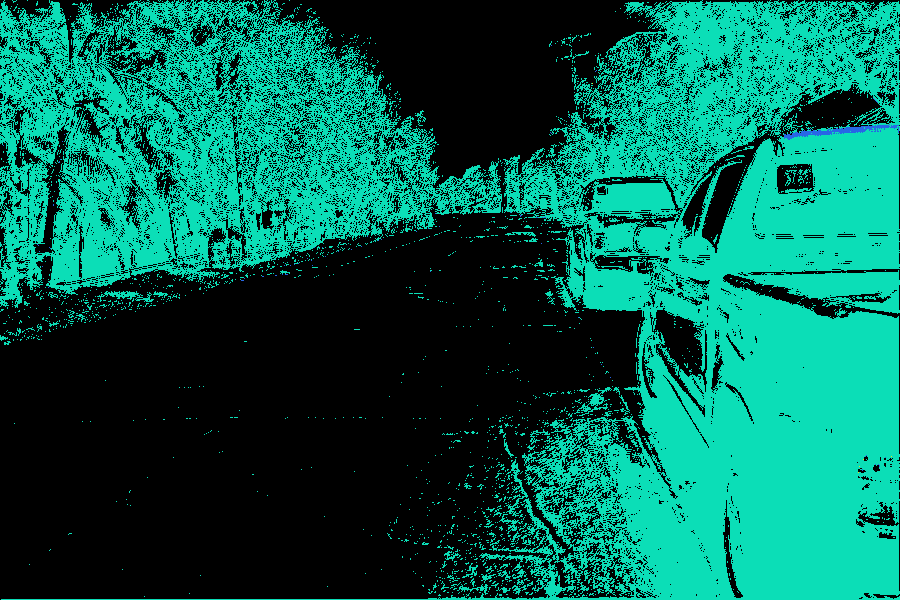

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(new_pred)

# Using DeepLabv3

In [ ]:
!gdown https://drive.google.com/uc?id=1fgZXgRirX_ixiKlf-6p-5sorkvsurxpe

Downloading...
From: https://drive.google.com/uc?id=1fgZXgRirX_ixiKlf-6p-5sorkvsurxpe
To: /content/deeplab_model_states.pth
184MB [00:02, 61.6MB/s]


In [ ]:
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, 
                          pin_memory=True, num_workers=4, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=4, 
                          pin_memory=True, num_workers=4, shuffle=True),
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 15
learning_rate = 0.0001

network = DeepLabV3("1").to(device)

params = add_weight_decay(network, l2_value=0.0001)
optimizer = torch.optim.Adam(params, lr=learning_rate)
epoch_losses_train = []
epoch_losses_val = []
# params = add_weight_decay(model, l2_value=0.0001)
# optimizer = torch.optim.Adam(params, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
for epoch in range(num_epochs):
    print ("###########################")
    print ("######## NEW EPOCH ########")
    print ("###########################")
    print ("epoch: %d/%d" % (epoch+1, num_epochs))

    ############################################################################
    # train:
    ############################################################################
    network.train() # (set in training mode, this affects BatchNorm and dropout)
    batch_losses = []
    for step, (inputs, labels) in enumerate(dataloaders['train']):
        #current_time = time.time()

        # imgs = Variable(imgs).cuda() # (shape: (batch_size, 3, img_h, img_w))
        # label_imgs = Variable(label_imgs.type(torch.LongTensor)).cuda() # (shape: (batch_size, img_h, img_w))
        inputs = inputs.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.squeeze()
        labels = labels.to(device)

        outputs = network(inputs) # (shape: (batch_size, num_classes, img_h, img_w))
        # print(outputs.shape, labels.shape)
        # compute the loss:
        # outputs = F.softmax(outputs)
        loss = loss_fn(outputs, labels)
        loss_value = loss.data.cpu().numpy()
        batch_losses.append(loss_value)

        # optimization step:
        optimizer.zero_grad() # (reset gradients)
        loss.backward() # (compute gradients)
        optimizer.step() # (perform optimization step)

        #print (time.time() - current_time)

    epoch_loss_train = np.mean(batch_losses)
    epoch_losses_train.append(epoch_loss_train)

    ############################################################################
    # val:
    ############################################################################
    network.eval() # (set in evaluation mode, this affects BatchNorm and dropout)
    batch_losses = []
    for step, (inputs, labels) in enumerate(dataloaders['val']):
        with torch.no_grad(): # (corresponds to setting volatile=True in all variables, this is done during inference to reduce memory consumption)
          # imgs = Variable(imgs).cuda() # (shape: (batch_size, 3, img_h, img_w))
          # label_imgs = Variable(label_imgs.type(torch.LongTensor)).cuda() # (shape: (batch_size, img_h, img_w))

          # outputs = network(imgs) # (shape: (batch_size, num_classes, img_h, img_w))
          inputs = inputs.to(device)
          labels = labels.type(torch.LongTensor)
          labels = labels.squeeze()
          labels = labels.to(device)
          outputs = network(inputs)
          # outputs = F.softmax(outputs)
          
          # print(outputs.shape, labels.shape)

          # compute the loss:
          loss = loss_fn(outputs, labels)
          loss_value = loss.data.cpu().numpy()
          batch_losses.append(loss_value)
    epoch_loss_val = np.mean(batch_losses)
    epoch_losses_val.append(epoch_loss_val)

    print("------------------------")
    print(f"Epoch {epoch}: Train Loss: {epoch_loss_train} Val Loss: {epoch_loss_val}")

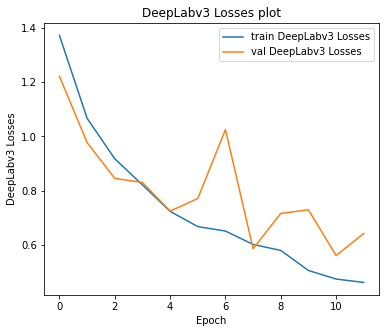

In [ ]:
def plot(scores, name):
    plt.figure(figsize=(6,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend();
    plt.savefig("hello.png") 
    plt.show()

new_scores = {
    'train': epoch_losses_train,
    'val': epoch_losses_val
}

plot(new_scores, "DeepLabv3 Losses")

In [ ]:
fake_loader = DataLoader(val_dataset, batch_size=1,
                          pin_memory=True, shuffle=True)
batch = next(iter(fake_loader)) # get a batch from the dataloader
images, masks = batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


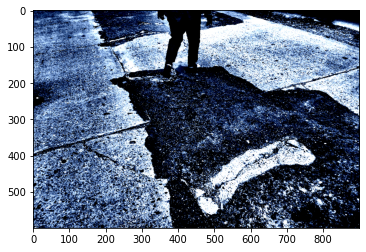

In [ ]:
plt.imshow(images[0].permute(1, 2, 0))

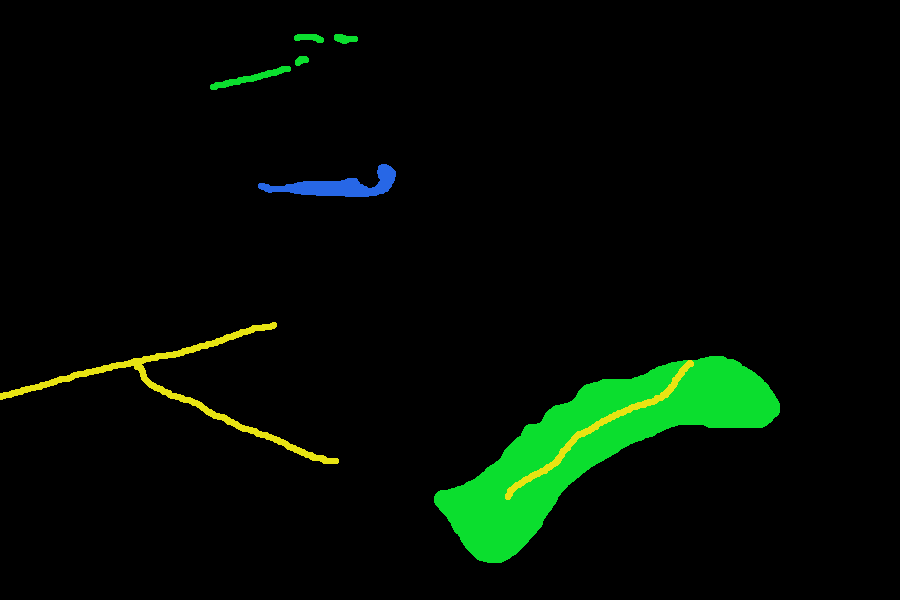

In [ ]:
new_mask = label_img_to_color(masks[0].squeeze().data.cpu().numpy())
from google.colab.patches import cv2_imshow
cv2_imshow(new_mask)

In [ ]:
# network = DeepLabV3("1").to(device)
# network.load_state_dict("deeplab_model_states.pth")
network = torch.load("deeplab_model_full.pth")

In [ ]:
with torch.no_grad():
  network.eval()
  # preds = torch.sigmoid(model.to(device)(images.to(device)))
  # preds = preds.detach().cpu().numpy()[:, 0, :, :] # (batch_size, 1, size, size) -> (batch_size, size, size)
  pred = network(images.to(device))
  print(pred.shape)
  # The loss functions include the sigmoid function.
  pred = F.softmax(pred)
  pred = pred.permute(0, 2, 3, 1)
  pred = pred.data.cpu().numpy()
  print(pred.shape)
  # pred = np.argmax(pred, axis=-1)
  # sample_output = torch.argmax(model(images.to(device)), 1)
  # print(sample_output.shape)
  # sample_output = sample_output.detach().cpu().numpy()

torch.Size([1, 6, 600, 900])
(1, 600, 900, 6)


In [ ]:
new_pred = pred[0]
new_pred = np.argmax(new_pred, axis=-1)
new_pred.shape

(600, 900)

In [ ]:
    # label_to_color = {
    #     0: [0, 0, 0],
    #     1: [52, 64, 235],   # kinda red     allgigator
    #     2: [230, 103, 39],  # kinda blue    bowl
    #     3: [46, 222, 11],   # kinda green   delamination
    #     4: [19, 228, 232],  # kinda yellow  crack
    #     5: [183, 222, 11]   # kinda sky blye  scaling
    #   }

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


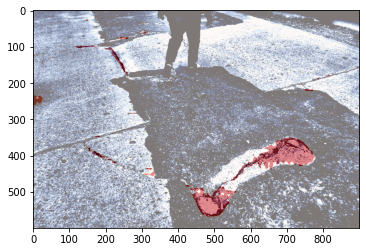

In [ ]:
plt.imshow(images[0].permute(1, 2, 0))
plt.imshow(new_pred, alpha=0.5, cmap="Reds")

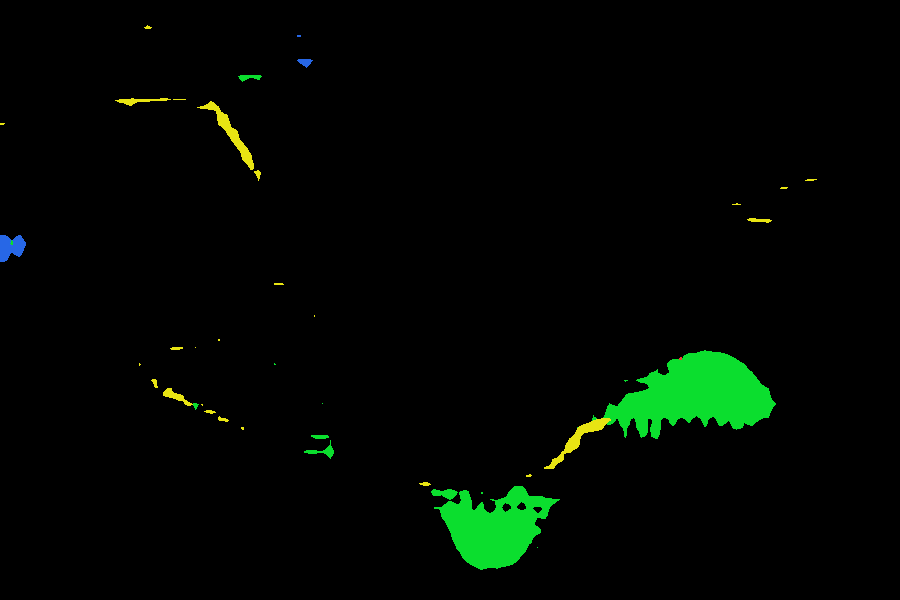

True

In [ ]:
new_pred = label_img_to_color(new_pred)
new_pred.shape
from google.colab.patches import cv2_imshow
cv2_imshow(new_pred)
cv2.imwrite("new.png", new_pred)

In [ ]:
def mask_generator(mask):
  mask_palette = [1, 2, 3, 4, 5]
  final_mask = []
  for palette in mask_palette:
    new_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float32)
    new_mask[mask == palette] = 1
    final_mask.append(new_mask)
  final_mask = np.array(final_mask)
  return final_mask

In [ ]:
def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]


def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou

# def dice_coef(y_true, y_pred, epsilon=1e-6):
#   """Altered Sorensen–Dice coefficient with epsilon for smoothing."""
#   y_true_flatten = np.asarray(y_true).astype(np.bool)
#   y_pred_flatten = np.asarray(y_pred).astype(np.bool)

#   if not np.sum(y_true_flatten) + np.sum(y_pred_flatten):
#       return 1.0

#   return (2. * np.sum(y_true_flatten * y_pred_flatten)) /\
#         (np.sum(y_true_flatten) + np.sum(y_pred_flatten) + epsilon)

# def dice_coef(y_true, y_pred):
#     y_true_f = y_true.flatten()
#     y_pred_f = y_pred.flatten()
#     intersection = np.sum(y_true_f * y_pred_f)
#     smooth = 0.0001
#     return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()
    # pred = (pred>0.5).float()   

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    coeff = ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth))
    
    return coeff.mean()

In [ ]:
fake_loader = DataLoader(val_dataset, batch_size=1,
                          pin_memory=True, shuffle=True)

with torch.no_grad():
  network.eval()

  dices = []

  for step, (inputs, labels) in enumerate(fake_loader):
    pred = network(inputs.to(device))
    pred = F.softmax(pred)
    # pred = pred.permute(0, 2, 3, 1)
    # pred = torch.argmax(pred, dim=1)
    # print(pred.shape, labels.shape)
    pred = pred.permute(0, 2, 3, 1)
    pred = pred.data.cpu().numpy()
    q = labels[0].cpu().numpy().squeeze()
    pred = np.argmax(pred, axis=-1).squeeze()
    # print(q.shape, pred.shape)
    dc = dice_loss(torch.from_numpy(mask_generator(q)).unsqueeze(1), torch.from_numpy(mask_generator(pred)).unsqueeze(1))
    dices.append(dc.numpy())

# q = masks[0].cpu().numpy().squeeze()
# diceeee = dice_loss(torch.from_numpy(mask_generator(q)).unsqueeze(1), torch.from_numpy(mask_generator(new_pred)).unsqueeze(1))
# diceeee

In [ ]:
dice_np = np.array(dices)
print(f"Mean Dice Coeff: {np.mean(dice_np)}")

Mean Dice Coeff: 0.578345537185669


In [ ]:
q = masks[0].cpu().numpy().squeeze()
iouuuu = compute_iou_batch(new_pred, q, classes = [1, 2, 3, 4, 5])
iouuuu

0.5582333397586164

In [ ]:
fake_loader = DataLoader(val_dataset, batch_size=1,
                          pin_memory=True, shuffle=True)

with torch.no_grad():
  network.eval()

  ious = []

  for step, (inputs, labels) in enumerate(fake_loader):
    pred = network(inputs.to(device))
    pred = F.softmax(pred)
    pred = pred.permute(0, 2, 3, 1)
    pred = pred.data.cpu().numpy()
    new_pred = pred[0]
    new_pred = np.argmax(new_pred, axis=-1)
    
    q = labels[0].cpu().numpy().squeeze()
    iouuuu = compute_iou_batch(new_pred, q, classes = [1, 2, 3, 4, 5])
    print(iouuuu, new_pred.shape, q.shape)
    ious.append(iouuuu)

In [ ]:
ious = np.array(ious)
print(f"Mean IoU Coeff: {np.mean(ious)}")

Mean IoU Coeff: 0.49786903684424416


In [ ]:
from PIL import Image
import torchvision

image_prefix = "/content/segmentation_dataset/new_img/"
color_mask_prefix = "/content/segmentation_dataset/new_color_mask/"
binary_mask_prefix = "/content/segmentation_dataset/mask/"


class DPWHDataset(Dataset):
  def __init__(self, mean=None, std=None, phase=None, dataset=None):
    self.data = dataset
    self.mean = mean
    self.std = std
    self.phase = phase
    self.transforms = get_transforms(phase, mean, std)
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image_name = self.data[idx]

    image_path = image_prefix + image_name + ".jpg"
    mask_path = binary_mask_prefix + image_name + "_mask.png"
    # print(mask_path)

    mask = cv2.imread(mask_path, 0)

    image = np.array(Image.open(image_path))
    # mask = np.array(Image.open(mask_path))
    mask = np.array(torchvision.transforms.ToPILImage()(mask))
    # image = cv2.imread(image_path)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    augmented = self.transforms(image=image, mask=mask)
    image = augmented['image']
    mask = augmented['mask']

    # mask = np.array(mask)

    mask = generate_mask(mask)

    image = torchvision.transforms.ToTensor()(image)
    image = torchvision.transforms.Normalize(mean=self.mean, std=self.std)(image)
    mask = torchvision.transforms.ToTensor()(mask).permute(1, 2, 0)
    return image, mask, image_name

val_dataset = DPWHDataset(
    mean = (0.485, 0.456, 0.406),
    std = (0.229, 0.224, 0.225),
    phase = 'val',
    dataset = validation_set
)

In [ ]:
!rm output_mask/*

In [ ]:
fake_loader = DataLoader(val_dataset, batch_size=1,
                          pin_memory=True, shuffle=True)

with torch.no_grad():
  network.eval()

  for step, (inputs, labels, image_name) in enumerate(fake_loader):
    image_name = image_name[0]
    print(image_name)
    pred = network(inputs.to(device))
    pred = F.softmax(pred)
    pred = pred.permute(0, 2, 3, 1)
    pred = pred.data.cpu().numpy()
    new_pred = pred[0]
    new_pred = np.argmax(new_pred, axis=-1)
    
    q = labels[0].cpu().numpy().squeeze()
    mask_image = label_img_to_color(q)
    predicted_image = label_img_to_color(new_pred)
    cv2.imwrite("output_mask/{}_mask.png".format(image_name), mask_image)
    cv2.imwrite("output_mask/{}_predicted.png".format(image_name), predicted_image)
    

delamination12
crack13
scaling70
crack53
delamination16
crack19
crack63
delamination4
crack18
scaling62
scaling49
bowldepression23
crack1
bowldepression17
scaling59
delamination9
alligator44
crack56
bowldepression27
alligator42
alligator20
alligator28
bowldepression46
crack24
scaling7
bowldepression22
bowldepression45
scaling21
delamination17
bowldepression21
alligator27
bowldepression40
crack23
crack69
crack38
scaling41
scaling68
scaling14
bowldepression36
alligator34
alligator6
delamination26
bowldepression62
crack27
bowldepression2
crack55
scaling47
bowldepression41
scaling48
delamination22
delamination1
scaling67
scaling13
crack36
scaling64


In [ ]:
!zip -r output_results.zip output_mask

  adding: output_mask/ (stored 0%)
  adding: output_mask/alligator27_predicted.png (deflated 47%)
  adding: output_mask/crack18_mask.png (deflated 59%)
  adding: output_mask/scaling21_mask.png (deflated 72%)
  adding: output_mask/alligator44_predicted.png (deflated 50%)
  adding: output_mask/scaling64_mask.png (deflated 60%)
  adding: output_mask/scaling67_mask.png (deflated 39%)
  adding: output_mask/crack13_mask.png (deflated 44%)
  adding: output_mask/delamination4_mask.png (deflated 67%)
  adding: output_mask/delamination17_mask.png (deflated 55%)
  adding: output_mask/crack19_mask.png (deflated 58%)
  adding: output_mask/scaling13_predicted.png (deflated 55%)
  adding: output_mask/alligator44_mask.png (deflated 61%)
  adding: output_mask/crack1_predicted.png (deflated 33%)
  adding: output_mask/scaling59_mask.png (deflated 50%)
  adding: output_mask/bowldepression22_mask.png (deflated 70%)
  adding: output_mask/crack27_predicted.png (deflated 42%)
  adding: output_mask/crack55_pre

In [ ]:
!cp output_results.zip drive/My\ Drive/